In [1]:
#Imports and libraries

import pandas as pd
import numpy as np
from numpy import linalg
import random as rand
import csv
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from sklearn import preprocessing
import collections
import math
import statistics

import sys  
sys.path.insert(0, '../scripts')
import krippendorff_alpha
import bootstrap_workers

sys.path.insert(0, '../scripts/xrr')
from xrr.xrr_class import xRR

import warnings
warnings.filterwarnings('ignore')

# Process experiment files and compute stats

In [2]:
#Read the data of the experiment
#drop videos that are annotatated by a single rater; 
#drop videos that are not annotated in all four repetitions

# To replicate the analysis, download the dataset from https://github.com/google-research-datasets/replication-dataset 
# and replace LINK_TO_SOURCE_FILE to the location of the dataset
link1 = '../data/LINK_TO_SOURCE_FILE'

repetitions = pd.read_csv(link1)

repetition1 = repetitions[repetitions["platform"] == "Budapest"]
repetition2 = repetitions[repetitions["platform"] == "Mexico"]
repetition3 = repetitions[repetitions["platform"] == "KualaLumpur"]
repetition4 = repetitions[repetitions["platform"] == "International"]

repetition1 = repetition1[repetition1.duplicated('item_id"', keep=False)]
repetition2 = repetition2[repetition2.duplicated('item_id"', keep=False)]
repetition3 = repetition3[repetition3.duplicated('item_id"', keep=False)]
repetition4 = repetition4[repetition4.duplicated('item_id"', keep=False)]

items1 = (list(set(repetition1['item_id"'])))
items2 = (list(set(repetition2['item_id"'])))
items3 = (list(set(repetition3['item_id"'])))
items4 = (list(set(repetition4['item_id"'])))
d = [items1, items2, items3, items4]

items = list(set.intersection(*map(set,d)))

repetition1 = repetition1[repetition1['item_id"'].isin(items)]
repetition2 = repetition2[repetition2['item_id"'].isin(items)]
repetition3 = repetition3[repetition3['item_id"'].isin(items)]
repetition4 = repetition4[repetition4['item_id"'].isin(items)]

reps = [repetition1, repetition2, repetition3, repetition4]
repsdf = pd.concat(reps)
repsdf.to_csv("../data/IREP_cleaned_data_release.csv", index=False)

In [3]:
#Get statistics about the number of judgments
print("Number of judgments in repetition Budapest: ", len(repetition1))
print("Number of judgments in repetition Mexico: ", len(repetition2))
print("Number of judgments in repetition KualaLumpur: ", len(repetition3))
print("Number of judgments in repetition International: ", len(repetition4))

Number of judgments in repetition Budapest:  2130
Number of judgments in repetition Mexico:  2130
Number of judgments in repetition KualaLumpur:  2130
Number of judgments in repetition International:  2130


In [4]:
#Get rater ids and the total number of raters per repetition
workerIds1 = list(set(list(repetition1["rater"])))
workerIds2 = list(set(list(repetition2["rater"])))
workerIds3 = list(set(list(repetition3["rater"])))
workerIds4 = list(set(list(repetition4["rater"])))

print("Number of workers in repetition Budapest: ", len(workerIds1))
print("Number of workers in repetition Mexico: ", len(workerIds2))
print("Number of workers in repetition KualaLumpur: ", len(workerIds3))
print("Number of workers in repetition International: ", len(workerIds4))


Number of workers in repetition Budapest:  2
Number of workers in repetition Mexico:  2
Number of workers in repetition KualaLumpur:  2
Number of workers in repetition International:  2


# Agreement Analysis

In [5]:
#compute Krippendorff's alpha for each repetition and emotion
missing = "*"

emotions = ["amusement", "anger", "awe", "boredom", "concentration", "confusion", "contemplation", 'contempt',
 'contentment', 'desire', 'disappointment', 'disgust', 'distress', 'doubt', 'ecstasy', 'elation', 'embarrassment',
 'error.other', 'fear', 'interest', 'love', 'neutral', "pain", "pride", "realization", "relief", "sadness",
 "shame", "surprise", "sympathy", "triumph", "unsure"]


repetition1 = repetition1.sort_values('item_id"')
repetition2 = repetition2.sort_values('item_id"')
repetition3 = repetition3.sort_values('item_id"')
repetition4 = repetition4.sort_values('item_id"')

def compute_agreement(repetition, worker_set, emotion):
    data = []
    for rater in worker_set:
        subset = repetition[repetition["rater"] == rater]
        row = list(subset[emotion])
        data.append(row)   
    alpha = krippendorff_alpha.krippendorff_alpha(data, missing_items=missing)
    return alpha
    

for emotion in emotions:
    print(emotion)
    alpha = compute_agreement(repetition1, workerIds1, emotion)
    print("Krippendorff's alpha Repetition Budapest: ", round(alpha, 4))

    alpha = compute_agreement(repetition2, workerIds2, emotion)
    print("Krippendorff's alpha Repetition Mexico: ", round(alpha, 4))

    alpha = compute_agreement(repetition3, workerIds3, emotion)
    print("Krippendorff's alpha Repetition KualaLumpur: ", round(alpha, 4))

    alpha = compute_agreement(repetition4, workerIds4, emotion)
    print("Krippendorff's alpha Repetition International: ", round(alpha, 4))


amusement
Krippendorff's alpha Repetition Budapest:  0.4228
Krippendorff's alpha Repetition Mexico:  0.1244
Krippendorff's alpha Repetition KualaLumpur:  0.6561
Krippendorff's alpha Repetition International:  0.2707
anger
Krippendorff's alpha Repetition Budapest:  0.4548
Krippendorff's alpha Repetition Mexico:  0.3903
Krippendorff's alpha Repetition KualaLumpur:  0.7216
Krippendorff's alpha Repetition International:  0.4442
awe
Krippendorff's alpha Repetition Budapest:  0.2508
Krippendorff's alpha Repetition Mexico:  0.1917
Krippendorff's alpha Repetition KualaLumpur:  0.2532
Krippendorff's alpha Repetition International:  0.0905
boredom
Krippendorff's alpha Repetition Budapest:  0.4947
Krippendorff's alpha Repetition Mexico:  0.3825
Krippendorff's alpha Repetition KualaLumpur:  0.5825
Krippendorff's alpha Repetition International:  0.2981
concentration
Krippendorff's alpha Repetition Budapest:  0.3378
Krippendorff's alpha Repetition Mexico:  0.397
Krippendorff's alpha Repetition Kuala

In [6]:
#compute IRR of the entire dataset

import nltk
from nltk.metrics import agreement
from nltk.metrics.distance import masi_distance
from nltk.metrics.distance import jaccard_distance


def compute_full_experiment_agreement(repetition, repetition_index):
    data = []
    for i in range(len(repetition)):
        c_emotions = []
        for emotion in emotions:
            if repetition[emotion].iloc[i] == 1:
                c_emotions.append(emotion)
        data_tuple = (repetition["rater"].iloc[i], repetition['item_id"'].iloc[i], frozenset(c_emotions))
        data.append(data_tuple)

    jaccard_task = nltk.AnnotationTask(distance=jaccard_distance)
    masi_task = nltk.AnnotationTask(distance=masi_distance)
    tasks = [masi_task, jaccard_task]
    print("Agreement for ", repetition_index)
    for task in tasks:
        task.load_array(data)
        print("Statistics for dataset using {}".format(task.distance))
        print("Pi: {}".format(round(task.pi(), 4)))
        print("Kappa: {}".format(round(task.kappa(), 4)))
        print("Multi-Kappa: {}".format(round(task.multi_kappa(), 4)))
    print("\n")

compute_full_experiment_agreement(repetition1, "Repetition 1")
compute_full_experiment_agreement(repetition2, "Repetition 2")
compute_full_experiment_agreement(repetition3, "Repetition 3")
compute_full_experiment_agreement(repetition4, "Repetition 4")

Agreement for  Repetition 1
Statistics for dataset using <function masi_distance at 0x7fa59b8d7b00>
Pi: 0.2513
Kappa: 0.2517
Multi-Kappa: 0.2517
Statistics for dataset using <function jaccard_distance at 0x7fa59b8d7a70>
Pi: 0.2956
Kappa: 0.296
Multi-Kappa: 0.296


Agreement for  Repetition 2
Statistics for dataset using <function masi_distance at 0x7fa59b8d7b00>
Pi: 0.2243
Kappa: 0.2284
Multi-Kappa: 0.2284
Statistics for dataset using <function jaccard_distance at 0x7fa59b8d7a70>
Pi: 0.2834
Kappa: 0.2872
Multi-Kappa: 0.2872


Agreement for  Repetition 3
Statistics for dataset using <function masi_distance at 0x7fa59b8d7b00>
Pi: 0.4904
Kappa: 0.4909
Multi-Kappa: 0.4909
Statistics for dataset using <function jaccard_distance at 0x7fa59b8d7a70>
Pi: 0.5684
Kappa: 0.5688
Multi-Kappa: 0.5688


Agreement for  Repetition 4
Statistics for dataset using <function masi_distance at 0x7fa59b8d7b00>
Pi: 0.1334
Kappa: 0.1337
Multi-Kappa: 0.1337
Statistics for dataset using <function jaccard_distance 

# Stability Analysis

In [7]:
#Process the results of all repetitions and compute stats (mean, stdev, variance)

import statistics as sts

emotions = ["amusement", "anger", "awe", "boredom", "concentration", "confusion", "contemplation", 'contempt',
 'contentment', 'desire', 'disappointment', 'disgust', 'distress', 'doubt', 'ecstasy', 'elation', 'embarrassment',
 'error.other', 'fear', 'interest', 'love', 'neutral', "pain", "pride", "realization", "relief", "sadness",
 "shame", "surprise", "sympathy", "triumph", "unsure"]

columns = ["item_id", "emotion", "Mean 1", "Stdev 1", "Variance 1", "Mean 2", "Stdev 2", "Variance 2",
           "Mean 3", "Stdev 3", "Variance 3", "Mean 4", "Stdev 4", "Variance 4"]
data = []
for item in items:
    sub1 = repetition1[repetition1['item_id"'] == item]
    sub2 = repetition2[repetition2['item_id"'] == item]
    sub3 = repetition3[repetition3['item_id"'] == item]
    sub4 = repetition4[repetition4['item_id"'] == item]

    for emotion in emotions:
        row = [item, emotion, sum(sub1[emotion])/2, sts.stdev(sub1[emotion]), sts.variance(sub1[emotion]),
           sum(sub2[emotion])/2, sts.stdev(sub2[emotion]), sts.variance(sub2[emotion]),
           sum(sub3[emotion])/2, sts.stdev(sub3[emotion]), sts.variance(sub3[emotion]),
           sum(sub4[emotion])/2, sts.stdev(sub4[emotion]), sts.variance(sub4[emotion])]

        data.append(row)

datadf = pd.DataFrame(data, columns = columns)
datadf

datadf.to_csv("../data/IREP_stats.csv", index=False)

In [8]:
#compute the Spearman's rank correlation between different runs
from itertools import combinations
from scipy.stats import spearmanr

for emotion in emotions:
    print(emotion)
    subset = datadf[datadf["emotion"] == emotion]
    combs = combinations(range(4), 2)
    for i in list(combs):
        rho, pval = spearmanr(subset["Mean " + str(i[0] + 1)], subset["Mean " + str(i[1] + 1)], axis=1)
        print("Spearman's rank correlation between repetition ", i[0] + 1, " & repetition ", i[1] + 1, ":", round(rho, 4), round(pval, 4))


amusement
Spearman's rank correlation between repetition  1  & repetition  2 : 0.4545 0.0
Spearman's rank correlation between repetition  1  & repetition  3 : 0.602 0.0
Spearman's rank correlation between repetition  1  & repetition  4 : 0.429 0.0
Spearman's rank correlation between repetition  2  & repetition  3 : 0.3762 0.0
Spearman's rank correlation between repetition  2  & repetition  4 : 0.3896 0.0
Spearman's rank correlation between repetition  3  & repetition  4 : 0.4189 0.0
anger
Spearman's rank correlation between repetition  1  & repetition  2 : 0.4898 0.0
Spearman's rank correlation between repetition  1  & repetition  3 : 0.535 0.0
Spearman's rank correlation between repetition  1  & repetition  4 : 0.4369 0.0
Spearman's rank correlation between repetition  2  & repetition  3 : 0.5182 0.0
Spearman's rank correlation between repetition  2  & repetition  4 : 0.5017 0.0
Spearman's rank correlation between repetition  3  & repetition  4 : 0.5469 0.0
awe
Spearman's rank correla

# Repeatability Analysis

In [9]:
# Compute the xRR score for each emotion

xrr = {}
for emotion in emotions:
    xrr[emotion] = []
    
scores = []

for emotion in emotions:
    print(emotion)
    
    xRR_object_41 = xRR(repetition4, repetition1, emotion, "rater", 'item_id"')
    xRR_object_42 = xRR(repetition4, repetition2, emotion, "rater", 'item_id"')
    xRR_object_43 = xRR(repetition4, repetition3, emotion, "rater", 'item_id"')
    
    new_xrr = [xRR_object_41.kappa_x(), xRR_object_42.kappa_x(), xRR_object_43.kappa_x()]
    xrr[emotion] = new_xrr
    scores.append(new_xrr)
    print("xRR score between International and Budapest raters:", round(xRR_object_41.kappa_x(), 4))
    print("xRR score between International and Mexico raters:", round(xRR_object_42.kappa_x(), 4))
    print("xRR score between International and KualaLumpur raters:", round(xRR_object_43.kappa_x(), 4))

amusement


22/08/2023 16:54:27  observed disagreement: 0.17887323943661973
22/08/2023 16:54:28  expected disagreement: 0.25385130816196083
22/08/2023 16:54:28  observed disagreement: 0.15774647887323945
22/08/2023 16:54:29  expected disagreement: 0.20121977561771254
22/08/2023 16:54:29  observed disagreement: 0.23708920187793428
22/08/2023 16:54:30  expected disagreement: 0.33023121514690645


xRR score between International and Budapest raters: 0.2954
xRR score between International and Mexico raters: 0.216
xRR score between International and KualaLumpur raters: 0.2821
anger


22/08/2023 16:54:30  observed disagreement: 0.05727699530516432
22/08/2023 16:54:31  expected disagreement: 0.09376710970045626
22/08/2023 16:54:31  observed disagreement: 0.04976525821596244
22/08/2023 16:54:32  expected disagreement: 0.08412484295444025
22/08/2023 16:54:32  observed disagreement: 0.05539906103286385
22/08/2023 16:54:33  expected disagreement: 0.10802089532500166


xRR score between International and Budapest raters: 0.3892
xRR score between International and Mexico raters: 0.4084
xRR score between International and KualaLumpur raters: 0.4871
awe


22/08/2023 16:54:33  observed disagreement: 0.09248826291079812
22/08/2023 16:54:34  expected disagreement: 0.0959946218783751
22/08/2023 16:54:34  observed disagreement: 0.10610328638497653
22/08/2023 16:54:35  expected disagreement: 0.11406643302695674
22/08/2023 16:54:35  observed disagreement: 0.07699530516431925
22/08/2023 16:54:36  expected disagreement: 0.0815371729595098


xRR score between International and Budapest raters: 0.0365
xRR score between International and Mexico raters: 0.0698
xRR score between International and KualaLumpur raters: 0.0557
boredom


22/08/2023 16:54:36  observed disagreement: 0.055868544600938964
22/08/2023 16:54:37  expected disagreement: 0.07559478939363883
22/08/2023 16:54:37  observed disagreement: 0.06901408450704226
22/08/2023 16:54:38  expected disagreement: 0.09373536996627653
22/08/2023 16:54:38  observed disagreement: 0.04929577464788732
22/08/2023 16:54:39  expected disagreement: 0.06926667989155591


xRR score between International and Budapest raters: 0.2609
xRR score between International and Mexico raters: 0.2637
xRR score between International and KualaLumpur raters: 0.2883
concentration


22/08/2023 16:54:39  observed disagreement: 0.19248826291079812
22/08/2023 16:54:40  expected disagreement: 0.241005091582358
22/08/2023 16:54:40  observed disagreement: 0.20234741784037558
22/08/2023 16:54:41  expected disagreement: 0.28463840948665386
22/08/2023 16:54:41  observed disagreement: 0.3380281690140845
22/08/2023 16:54:42  expected disagreement: 0.4373550221516895


xRR score between International and Budapest raters: 0.2013
xRR score between International and Mexico raters: 0.2891
xRR score between International and KualaLumpur raters: 0.2271
confusion


22/08/2023 16:54:42  observed disagreement: 0.10422535211267606
22/08/2023 16:54:43  expected disagreement: 0.12700081553483655
22/08/2023 16:54:43  observed disagreement: 0.10046948356807511
22/08/2023 16:54:44  expected disagreement: 0.11489298860455377
22/08/2023 16:54:44  observed disagreement: 0.08873239436619719
22/08/2023 16:54:45  expected disagreement: 0.11450241354228659


xRR score between International and Budapest raters: 0.1793
xRR score between International and Mexico raters: 0.1255
xRR score between International and KualaLumpur raters: 0.2251
contemplation


22/08/2023 16:54:45  observed disagreement: 0.13943661971830987
22/08/2023 16:54:46  expected disagreement: 0.15206374396614428
22/08/2023 16:54:46  observed disagreement: 0.12206572769953052
22/08/2023 16:54:47  expected disagreement: 0.1296660715466508
22/08/2023 16:54:47  observed disagreement: 0.11126760563380282
22/08/2023 16:54:48  expected disagreement: 0.12310123652714408


xRR score between International and Budapest raters: 0.083
xRR score between International and Mexico raters: 0.0586
xRR score between International and KualaLumpur raters: 0.0961
contempt


22/08/2023 16:54:48  observed disagreement: 0.0539906103286385
22/08/2023 16:54:49  expected disagreement: 0.062253521126760566
22/08/2023 16:54:49  observed disagreement: 0.044131455399061034
22/08/2023 16:54:50  expected disagreement: 0.04735524256651017
22/08/2023 16:54:50  observed disagreement: 0.05117370892018779
22/08/2023 16:54:51  expected disagreement: 0.057433489827856024


xRR score between International and Budapest raters: 0.1327
xRR score between International and Mexico raters: 0.0681
xRR score between International and KualaLumpur raters: 0.109
contentment


22/08/2023 16:54:51  observed disagreement: 0.19342723004694837
22/08/2023 16:54:52  expected disagreement: 0.2081227269721616
22/08/2023 16:54:52  observed disagreement: 0.26384976525821596
22/08/2023 16:54:53  expected disagreement: 0.2832744825762084
22/08/2023 16:54:53  observed disagreement: 0.10985915492957747
22/08/2023 16:54:54  expected disagreement: 0.12955498247702177


xRR score between International and Budapest raters: 0.0706
xRR score between International and Mexico raters: 0.0686
xRR score between International and KualaLumpur raters: 0.152
desire


22/08/2023 16:54:54  observed disagreement: 0.038028169014084505
22/08/2023 16:54:55  expected disagreement: 0.047571249090788865
22/08/2023 16:54:55  observed disagreement: 0.04037558685446009
22/08/2023 16:54:56  expected disagreement: 0.04800502545791179
22/08/2023 16:54:56  observed disagreement: 0.04366197183098591
22/08/2023 16:54:57  expected disagreement: 0.058849434635984924


xRR score between International and Budapest raters: 0.2006
xRR score between International and Mexico raters: 0.1589
xRR score between International and KualaLumpur raters: 0.2581
disappointment


22/08/2023 16:54:57  observed disagreement: 0.05821596244131456
22/08/2023 16:54:58  expected disagreement: 0.06353898036103947
22/08/2023 16:54:58  observed disagreement: 0.056338028169014086
22/08/2023 16:54:59  expected disagreement: 0.06056117613348322
22/08/2023 16:54:59  observed disagreement: 0.051643192488262914
22/08/2023 16:55:00  expected disagreement: 0.06056117613348322


xRR score between International and Budapest raters: 0.0838
xRR score between International and Mexico raters: 0.0697
xRR score between International and KualaLumpur raters: 0.1473
disgust


22/08/2023 16:55:00  observed disagreement: 0.05352112676056338
22/08/2023 16:55:01  expected disagreement: 0.06333090877030571
22/08/2023 16:55:01  observed disagreement: 0.05727699530516432
22/08/2023 16:55:02  expected disagreement: 0.0670880998038308
22/08/2023 16:55:02  observed disagreement: 0.06525821596244132
22/08/2023 16:55:03  expected disagreement: 0.0783596729044061


xRR score between International and Budapest raters: 0.1549
xRR score between International and Mexico raters: 0.1462
xRR score between International and KualaLumpur raters: 0.1672
distress


22/08/2023 16:55:03  observed disagreement: 0.09014084507042254
22/08/2023 16:55:04  expected disagreement: 0.09771341665013555
22/08/2023 16:55:04  observed disagreement: 0.09718309859154929
22/08/2023 16:55:05  expected disagreement: 0.1094619674226895
22/08/2023 16:55:05  observed disagreement: 0.07605633802816901
22/08/2023 16:55:06  expected disagreement: 0.0863699883180145


xRR score between International and Budapest raters: 0.0775
xRR score between International and Mexico raters: 0.1122
xRR score between International and KualaLumpur raters: 0.1194
doubt


22/08/2023 16:55:06  observed disagreement: 0.07370892018779343
22/08/2023 16:55:07  expected disagreement: 0.07406687385659812
22/08/2023 16:55:07  observed disagreement: 0.06291079812206572
22/08/2023 16:55:08  expected disagreement: 0.0641914082302894
22/08/2023 16:55:08  observed disagreement: 0.04647887323943662
22/08/2023 16:55:09  expected disagreement: 0.04658731733121735


xRR score between International and Budapest raters: 0.0048
xRR score between International and Mexico raters: 0.0199
xRR score between International and KualaLumpur raters: 0.0023
ecstasy


22/08/2023 16:55:10  observed disagreement: 0.05117370892018779
22/08/2023 16:55:11  expected disagreement: 0.05536159051334612
22/08/2023 16:55:11  observed disagreement: 0.046009389671361506
22/08/2023 16:55:12  expected disagreement: 0.05145363574246732
22/08/2023 16:55:12  observed disagreement: 0.03943661971830986
22/08/2023 16:55:12  expected disagreement: 0.03929555423306663


xRR score between International and Budapest raters: 0.0756
xRR score between International and Mexico raters: 0.1058
xRR score between International and KualaLumpur raters: -0.0036
elation


22/08/2023 16:55:13  observed disagreement: 0.11502347417840375
22/08/2023 16:55:14  expected disagreement: 0.12892018779342723
22/08/2023 16:55:14  observed disagreement: 0.12300469483568074
22/08/2023 16:55:15  expected disagreement: 0.15258215962441316
22/08/2023 16:55:15  observed disagreement: 0.107981220657277
22/08/2023 16:55:16  expected disagreement: 0.12591549295774648


xRR score between International and Budapest raters: 0.1078
xRR score between International and Mexico raters: 0.1938
xRR score between International and KualaLumpur raters: 0.1424
embarrassment


22/08/2023 16:55:16  observed disagreement: 0.061971830985915494
22/08/2023 16:55:17  expected disagreement: 0.06665740924419758
22/08/2023 16:55:17  observed disagreement: 0.04225352112676056
22/08/2023 16:55:18  expected disagreement: 0.044968590888051316
22/08/2023 16:55:18  observed disagreement: 0.04131455399061033
22/08/2023 16:55:19  expected disagreement: 0.044101038153805464


xRR score between International and Budapest raters: 0.0703
xRR score between International and Mexico raters: 0.0604
xRR score between International and KualaLumpur raters: 0.0632
error.other


22/08/2023 16:55:19  observed disagreement: 0.022535211267605635
22/08/2023 16:55:20  expected disagreement: 0.022535211267605635
22/08/2023 16:55:20  observed disagreement: 0.022535211267605635
22/08/2023 16:55:21  expected disagreement: 0.022535211267605635
22/08/2023 16:55:21  observed disagreement: 0.022535211267605635
22/08/2023 16:55:22  expected disagreement: 0.022535211267605635
22/08/2023 16:55:22  observed disagreement: 0.022535211267605635
22/08/2023 16:55:23  expected disagreement: 0.022535211267605635


xRR score between International and Budapest raters: 0.0


22/08/2023 16:55:23  observed disagreement: 0.022535211267605635
22/08/2023 16:55:23  expected disagreement: 0.022535211267605635


xRR score between International and Mexico raters: 0.0


22/08/2023 16:55:24  observed disagreement: 0.022535211267605635
22/08/2023 16:55:24  expected disagreement: 0.022535211267605635


xRR score between International and KualaLumpur raters: 0.0
fear


22/08/2023 16:55:25  observed disagreement: 0.04976525821596244
22/08/2023 16:55:26  expected disagreement: 0.06557032334854196
22/08/2023 16:55:26  observed disagreement: 0.04647887323943662
22/08/2023 16:55:27  expected disagreement: 0.07229914699464392
22/08/2023 16:55:27  observed disagreement: 0.044131455399061034
22/08/2023 16:55:27  expected disagreement: 0.07440190438405078


xRR score between International and Budapest raters: 0.241
xRR score between International and Mexico raters: 0.3571
xRR score between International and KualaLumpur raters: 0.4069
interest


22/08/2023 16:55:28  observed disagreement: 0.22018779342723005
22/08/2023 16:55:29  expected disagreement: 0.24294341951552823
22/08/2023 16:55:29  observed disagreement: 0.21784037558685446
22/08/2023 16:55:30  expected disagreement: 0.24065992197315347
22/08/2023 16:55:30  observed disagreement: 0.2784037558685446
22/08/2023 16:55:31  expected disagreement: 0.3078599925058961


xRR score between International and Budapest raters: 0.0937
xRR score between International and Mexico raters: 0.0948
xRR score between International and KualaLumpur raters: 0.0957
love


22/08/2023 16:55:32  observed disagreement: 0.09295774647887324
22/08/2023 16:55:32  expected disagreement: 0.1310057528268201
22/08/2023 16:55:33  observed disagreement: 0.09201877934272301
22/08/2023 16:55:33  expected disagreement: 0.1532434040864908
22/08/2023 16:55:34  observed disagreement: 0.08544600938967137
22/08/2023 16:55:34  expected disagreement: 0.15475104146002777


xRR score between International and Budapest raters: 0.2904
xRR score between International and Mexico raters: 0.3995
xRR score between International and KualaLumpur raters: 0.4478
neutral


22/08/2023 16:55:35  observed disagreement: 0.1352112676056338
22/08/2023 16:55:36  expected disagreement: 0.1581524829729551
22/08/2023 16:55:36  observed disagreement: 0.18309859154929578
22/08/2023 16:55:37  expected disagreement: 0.20899689215102824
22/08/2023 16:55:37  observed disagreement: 0.115962441314554
22/08/2023 16:55:37  expected disagreement: 0.118847230487778


xRR score between International and Budapest raters: 0.1451
xRR score between International and Mexico raters: 0.1239
xRR score between International and KualaLumpur raters: 0.0243
pain


22/08/2023 16:55:38  observed disagreement: 0.030985915492957747
22/08/2023 16:55:39  expected disagreement: 0.03531971169741453
22/08/2023 16:55:39  observed disagreement: 0.02910798122065728
22/08/2023 16:55:39  expected disagreement: 0.03355286649474311
22/08/2023 16:55:40  observed disagreement: 0.030985915492957747
22/08/2023 16:55:40  expected disagreement: 0.03531971169741453


xRR score between International and Budapest raters: 0.1227
xRR score between International and Mexico raters: 0.1325
xRR score between International and KualaLumpur raters: 0.1227
pride


22/08/2023 16:55:41  observed disagreement: 0.10375586854460093
22/08/2023 16:55:42  expected disagreement: 0.11558244616368005
22/08/2023 16:55:42  observed disagreement: 0.07464788732394366
22/08/2023 16:55:43  expected disagreement: 0.08004805043091097
22/08/2023 16:55:43  observed disagreement: 0.07511737089201878
22/08/2023 16:55:44  expected disagreement: 0.08408604994599837


xRR score between International and Budapest raters: 0.1023
xRR score between International and Mexico raters: 0.0675
xRR score between International and KualaLumpur raters: 0.1067
realization


22/08/2023 16:55:44  observed disagreement: 0.08873239436619719
22/08/2023 16:55:45  expected disagreement: 0.08834622760034384
22/08/2023 16:55:45  observed disagreement: 0.057746478873239436
22/08/2023 16:55:46  expected disagreement: 0.05738852520443475
22/08/2023 16:55:46  observed disagreement: 0.056338028169014086
22/08/2023 16:55:47  expected disagreement: 0.056970177874760296


xRR score between International and Budapest raters: -0.0044
xRR score between International and Mexico raters: -0.0062
xRR score between International and KualaLumpur raters: 0.0111
relief


22/08/2023 16:55:47  observed disagreement: 0.038028169014084505
22/08/2023 16:55:48  expected disagreement: 0.04142432057131522
22/08/2023 16:55:48  observed disagreement: 0.03145539906103286
22/08/2023 16:55:49  expected disagreement: 0.03298155127950803
22/08/2023 16:55:49  observed disagreement: 0.0568075117370892
22/08/2023 16:55:50  expected disagreement: 0.06230906566157508


xRR score between International and Budapest raters: 0.082
xRR score between International and Mexico raters: 0.0463
xRR score between International and KualaLumpur raters: 0.0883
sadness


22/08/2023 16:55:50  observed disagreement: 0.050234741784037557
22/08/2023 16:55:51  expected disagreement: 0.07317507549207608
22/08/2023 16:55:51  observed disagreement: 0.04507042253521127
22/08/2023 16:55:52  expected disagreement: 0.06842778108400009
22/08/2023 16:55:52  observed disagreement: 0.045539906103286384
22/08/2023 16:55:53  expected disagreement: 0.06842778108400009


xRR score between International and Budapest raters: 0.3135
xRR score between International and Mexico raters: 0.3413
xRR score between International and KualaLumpur raters: 0.3345
shame


22/08/2023 16:55:53  observed disagreement: 0.023943661971830985
22/08/2023 16:55:54  expected disagreement: 0.025580903259935197
22/08/2023 16:55:54  observed disagreement: 0.022535211267605635
22/08/2023 16:55:55  expected disagreement: 0.02242412219797659
22/08/2023 16:55:55  observed disagreement: 0.01971830985915493
22/08/2023 16:55:56  expected disagreement: 0.020169278582291873


xRR score between International and Budapest raters: 0.064
xRR score between International and Mexico raters: -0.005
xRR score between International and KualaLumpur raters: 0.0224
surprise


22/08/2023 16:55:56  observed disagreement: 0.11455399061032864
22/08/2023 16:55:57  expected disagreement: 0.15089201877934272
22/08/2023 16:55:57  observed disagreement: 0.1028169014084507
22/08/2023 16:55:58  expected disagreement: 0.1316021953316141
22/08/2023 16:55:58  observed disagreement: 0.09859154929577464
22/08/2023 16:55:59  expected disagreement: 0.13916683197778218


xRR score between International and Budapest raters: 0.2408
xRR score between International and Mexico raters: 0.2187
xRR score between International and KualaLumpur raters: 0.2916
sympathy


22/08/2023 16:56:00  observed disagreement: 0.06056338028169014
22/08/2023 16:56:00  expected disagreement: 0.062024730542881705
22/08/2023 16:56:00  observed disagreement: 0.03051643192488263
22/08/2023 16:56:01  expected disagreement: 0.032826379245740486
22/08/2023 16:56:01  observed disagreement: 0.03333333333333333
22/08/2023 16:56:02  expected disagreement: 0.03731843329145452


xRR score between International and Budapest raters: 0.0236
xRR score between International and Mexico raters: 0.0704
xRR score between International and KualaLumpur raters: 0.1068
triumph


22/08/2023 16:56:03  observed disagreement: 0.03568075117370892
22/08/2023 16:56:03  expected disagreement: 0.04211994974542088
22/08/2023 16:56:04  observed disagreement: 0.038028169014084505
22/08/2023 16:56:04  expected disagreement: 0.041682205911525494
22/08/2023 16:56:04  observed disagreement: 0.03474178403755868
22/08/2023 16:56:05  expected disagreement: 0.03993123057594393


xRR score between International and Budapest raters: 0.1529
xRR score between International and Mexico raters: 0.0877
xRR score between International and KualaLumpur raters: 0.13
unsure


22/08/2023 16:56:06  observed disagreement: 0.04366197183098591
22/08/2023 16:56:06  expected disagreement: 0.04366197183098591
22/08/2023 16:56:07  observed disagreement: 0.03474178403755868
22/08/2023 16:56:07  expected disagreement: 0.03474178403755868
22/08/2023 16:56:08  observed disagreement: 0.002347417840375587
22/08/2023 16:56:08  expected disagreement: 0.002347417840375587
22/08/2023 16:56:08  observed disagreement: 0.04366197183098591
22/08/2023 16:56:09  expected disagreement: 0.04366197183098591


xRR score between International and Budapest raters: 0.0


22/08/2023 16:56:09  observed disagreement: 0.03474178403755868
22/08/2023 16:56:10  expected disagreement: 0.03474178403755868


xRR score between International and Mexico raters: 0.0


22/08/2023 16:56:10  observed disagreement: 0.002347417840375587
22/08/2023 16:56:11  expected disagreement: 0.002347417840375587


xRR score between International and KualaLumpur raters: 0.0


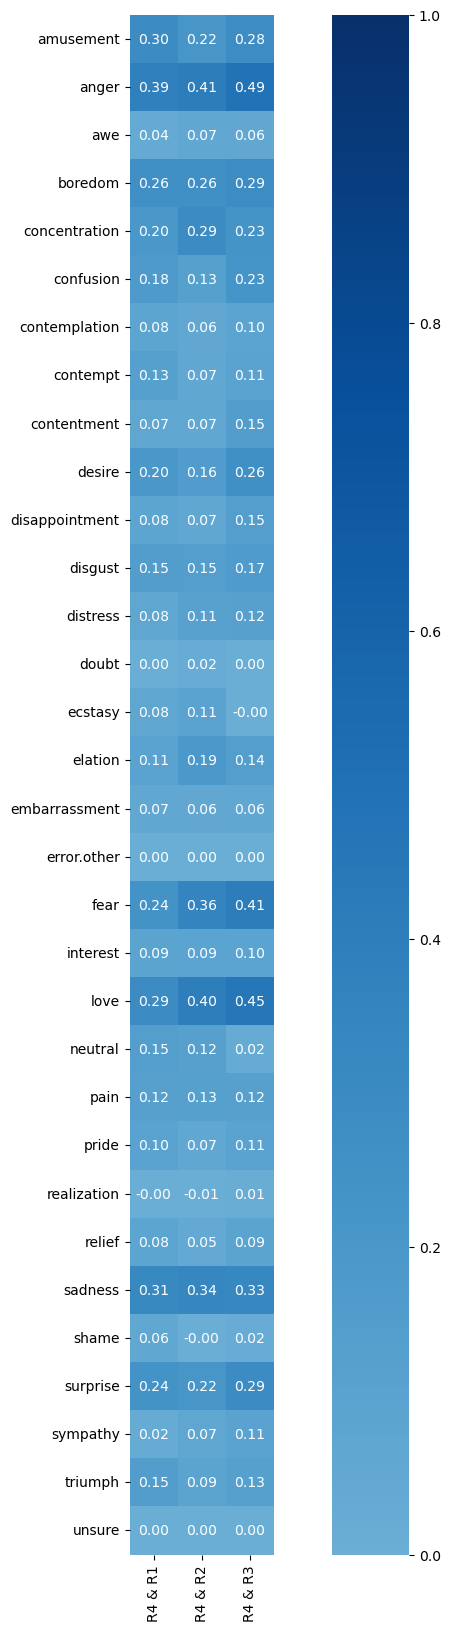

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(15,20))
sns.heatmap(scores, center=0, annot=True,
            fmt='.2f', square=True, cmap="Blues", xticklabels=["R4 & R1", "R4 & R2", "R4 & R3"],  yticklabels=emotions,
            vmin=0.0, vmax=1.0)
#ax.set_yticks(["R1", "R2", "R3", "R4", "R5"])
plt.savefig("../plots/xRR_IRep.png",  bbox_inches='tight', format='png', dpi=1200)
plt.show()